# PyML Chapter 5 - Dimensionalitiy Reduction

In [2]:
from IPython.display import Image
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
IMAGE_PATH = r'datasets/ch5images/'
DATASET_PATH = r'datasets/wine.data'

# Contents

- [**Principal Component Analysis (PCA)**](#pca) for unsupervised data compression
    - [Part 1]
- [**Linear Discriminant Analysis (LDA)**](#lda) supervised DR for maximising class separability
    - [asdf]
- [**Kernal Principal Component Analysis**](#kpca) for non-linear DR

# Principal Component Analysis (PCA) <a name='pca'></a>

PCA finds orthogonal directions of maximal variance, these become the principal components. Note that the PCA directions are highly sensitive to scaling and so we need to standardize the features prior to PCA - i.e. assign equal importance to all features.

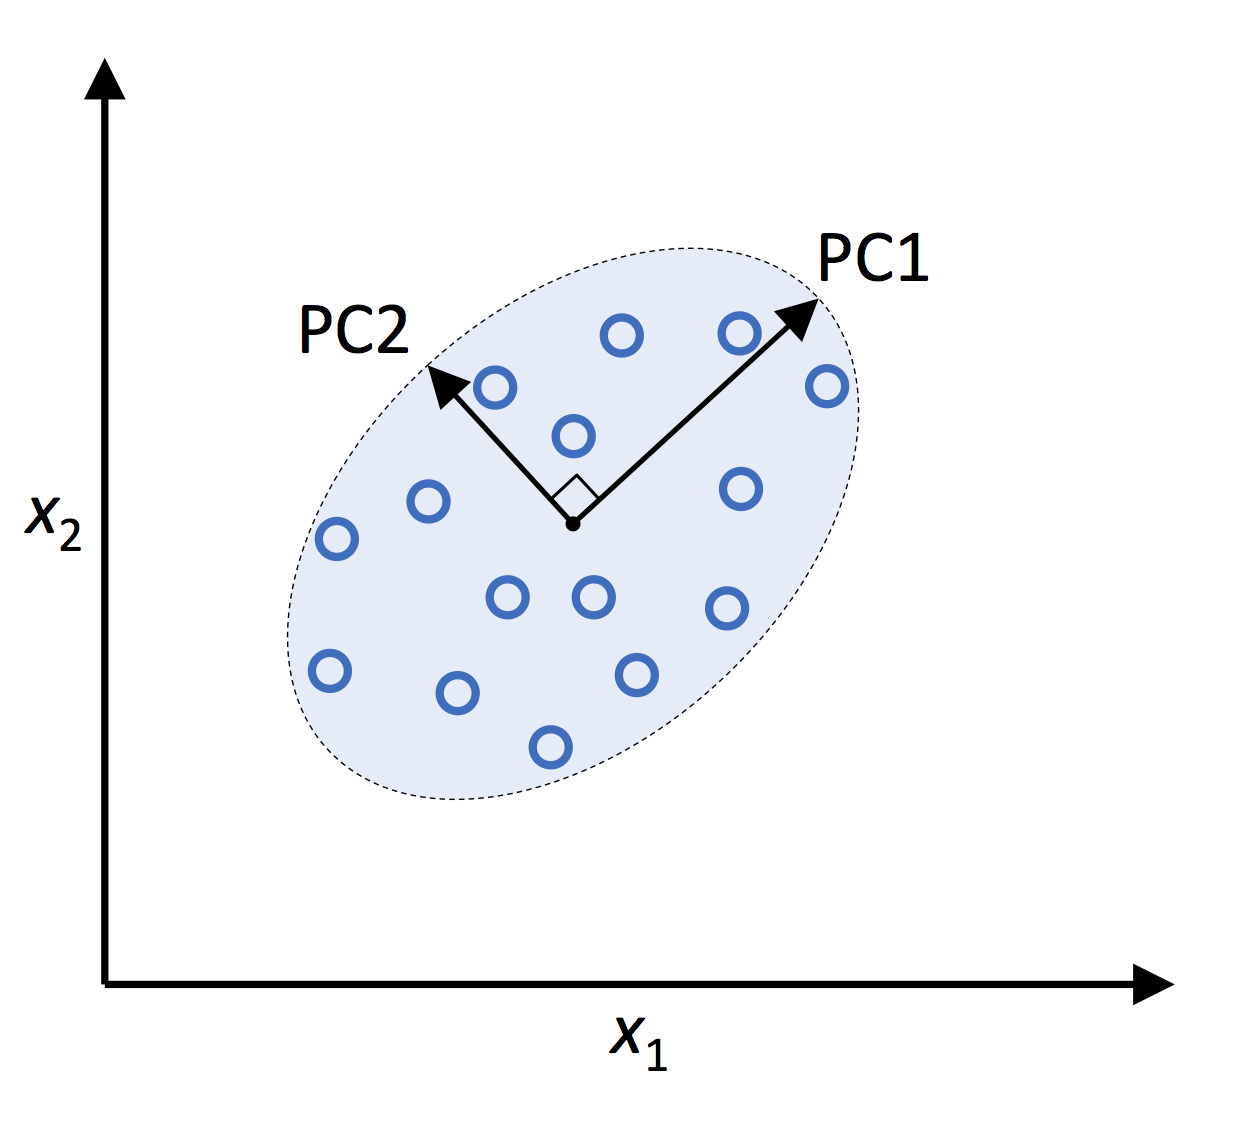

In [3]:
Image(filename=IMAGE_PATH + '05_01.png', width=400)

The approach can be summarised in a number of steps:
- 1. Standardise the d-dimensional dataset
- 2. Construct the Covariance matrix
- 3. Decompose the cov matrix into eigenvalues and eigenvectors
- 4. Sort these into descending order
- 5. Select the k largest eigenvalues, where k is the new dimensionality
- 6. Construct a projection matrix **W**
- 7. Transform the d-dimensional input dataset **X** using the projection matrix

In [4]:
df_wine = pd.read_csv(DATASET_PATH, header=None)
df_wine.columns = ['class_label', 'alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids',
                   'non_flavanoid_phenols', 'proanthocyanins', 'colour_intensity', 'hue', 'OD280/OD325_of_diluted_wines', 'proline']
df_wine.head(2)

,class_label,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,non_flavanoid_phenols,proanthocyanins,colour_intensity,hue,OD280/OD325_of_diluted_wines,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050


### 1. Split and Standardise Data

In [5]:
from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

In [6]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

### 2-4. The Covariance Matrix

In [7]:
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('\nEignenvalues:\n', eigen_vals)


Eignenvalues:
 [4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ]


Note that `linalg.eigh` is availble for hermetian matricies (a complex square matrix, equal to its conjugate transpose). This is generally more stable if decomposing a symmetric matrix such as the covariance matrix.

We can see how imformative each eigenvalue is by plotting the **variance explained ratios**: $\frac{\lambda_j}{\sum^{d}_{j=1}\lambda_j}$.

In [8]:
tot = sum(eigen_vals)
var_exp = [(i/tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

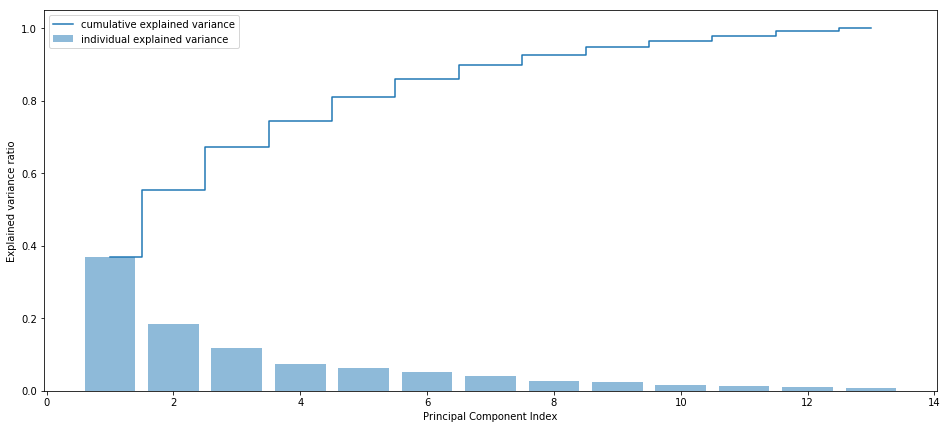

In [9]:
fig = plt.figure(figsize=(16, 7))
plt.bar(range(1,14), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio'); plt.xlabel('Principal Component Index')
plt.legend()
plt.show()

The first principal component accounts for almost 40% of the total, and the first two, almost 60%!

### 5-7. Feature Transformation

In [10]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(key=lambda k: k[0], reverse=True)
print(eigen_pairs[0], '\n', eigen_pairs[1])

(4.842745315655895, array([-0.13724218,  0.24724326, -0.02545159,  0.20694508, -0.15436582,
       -0.39376952, -0.41735106,  0.30572896, -0.30668347,  0.07554066,
       -0.32613263, -0.36861022, -0.29669651])) 
 (2.416024587035225, array([ 0.50303478,  0.16487119,  0.24456476, -0.11352904,  0.28974518,
        0.05080104, -0.02287338,  0.09048885,  0.00835233,  0.54977581,
       -0.20716433, -0.24902536,  0.38022942]))


Choose the two highest eigen-pairs for illustration purposes.

In [11]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


Then transforming the whole dataset: $X' = XW$

In [12]:
X_train_pca = X_train_std.dot(w)
print(X_train_pca[0:5])  # print the first 5 datapoints

[[ 2.38299011  0.45458499]
 [-1.96578183  1.65376939]
 [-2.53907598  1.02909066]
 [-1.43010776  0.6024011 ]
 [ 3.14147227  0.66214979]]


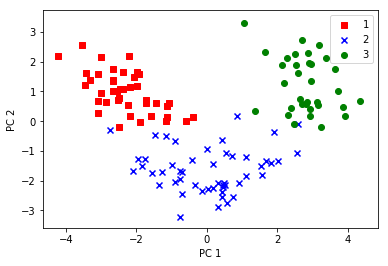

In [13]:
colours, markers = ['r', 'b', 'g'], ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colours, markers):
    plt.scatter(X_train_pca[y_train==l, 0], X_train_pca[y_train==l, 1], c=c, label=l, marker=m)
plt.xlabel('PC 1'); plt.ylabel('PC 2')
plt.legend()
plt.show()

## Using Sklearn

In [14]:
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, resolution=0.01):
    
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'grey', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min()-1, X[:, 0].max()+1
    x2_min, x2_max = X[:, 1].min()-1, X[:, 1].max()+1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x2_max ,resolution),
                          np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl, 0], y=X[y==cl, 1], alpha=0.6, color=cmap(idx), edgecolor='black', marker=markers[idx], label=cl)
    

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
lr = LogisticRegression(solver='lbfgs', multi_class='auto')
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
lr.fit(X_train_pca, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

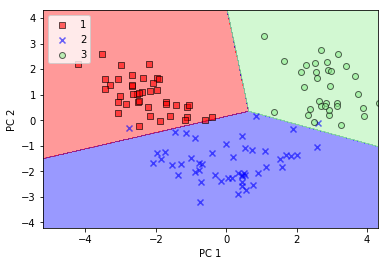

In [16]:
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1'); plt.ylabel('PC 2')
plt.legend()
plt.show()

Note that if we did this with our PCA implementation the images may be flipped - this is just a quirk of the eigensolver. Multiply by -1 to solve this!

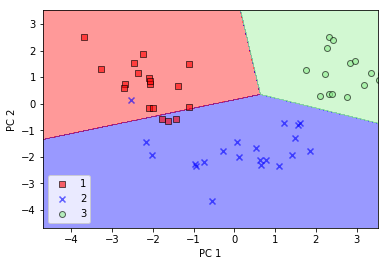

In [17]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1'); plt.ylabel('PC 2')
plt.legend()
plt.show()

If we want to know the explained variance ratios of the different principal components we can simply initialise the PCA class with n_components=None so all principal components are kept:

In [18]:
pca = PCA(n_components=None)  # return all PCs in sorted order rather than performing dimensionality reduction
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([0.36951469, 0.18434927, 0.11815159, 0.07334252, 0.06422108,
       0.05051724, 0.03954654, 0.02643918, 0.02389319, 0.01629614,
       0.01380021, 0.01172226, 0.00820609])

# Linear Discriminant Analysis (LDA) <a name='lda'></a>

Rather than maximising variance, the goal of LDA is to find the feature subpace that optimises class separabilites, which is possible as LDA is supervised. LDA is sometimes called Fisher's LDA as Fisher first introducted the Fisher's Linear Discriminant for two-class problems, which was then generalised to multiclass problems under the assumption of equal class covariances and normally distributed classed - this is LDA.

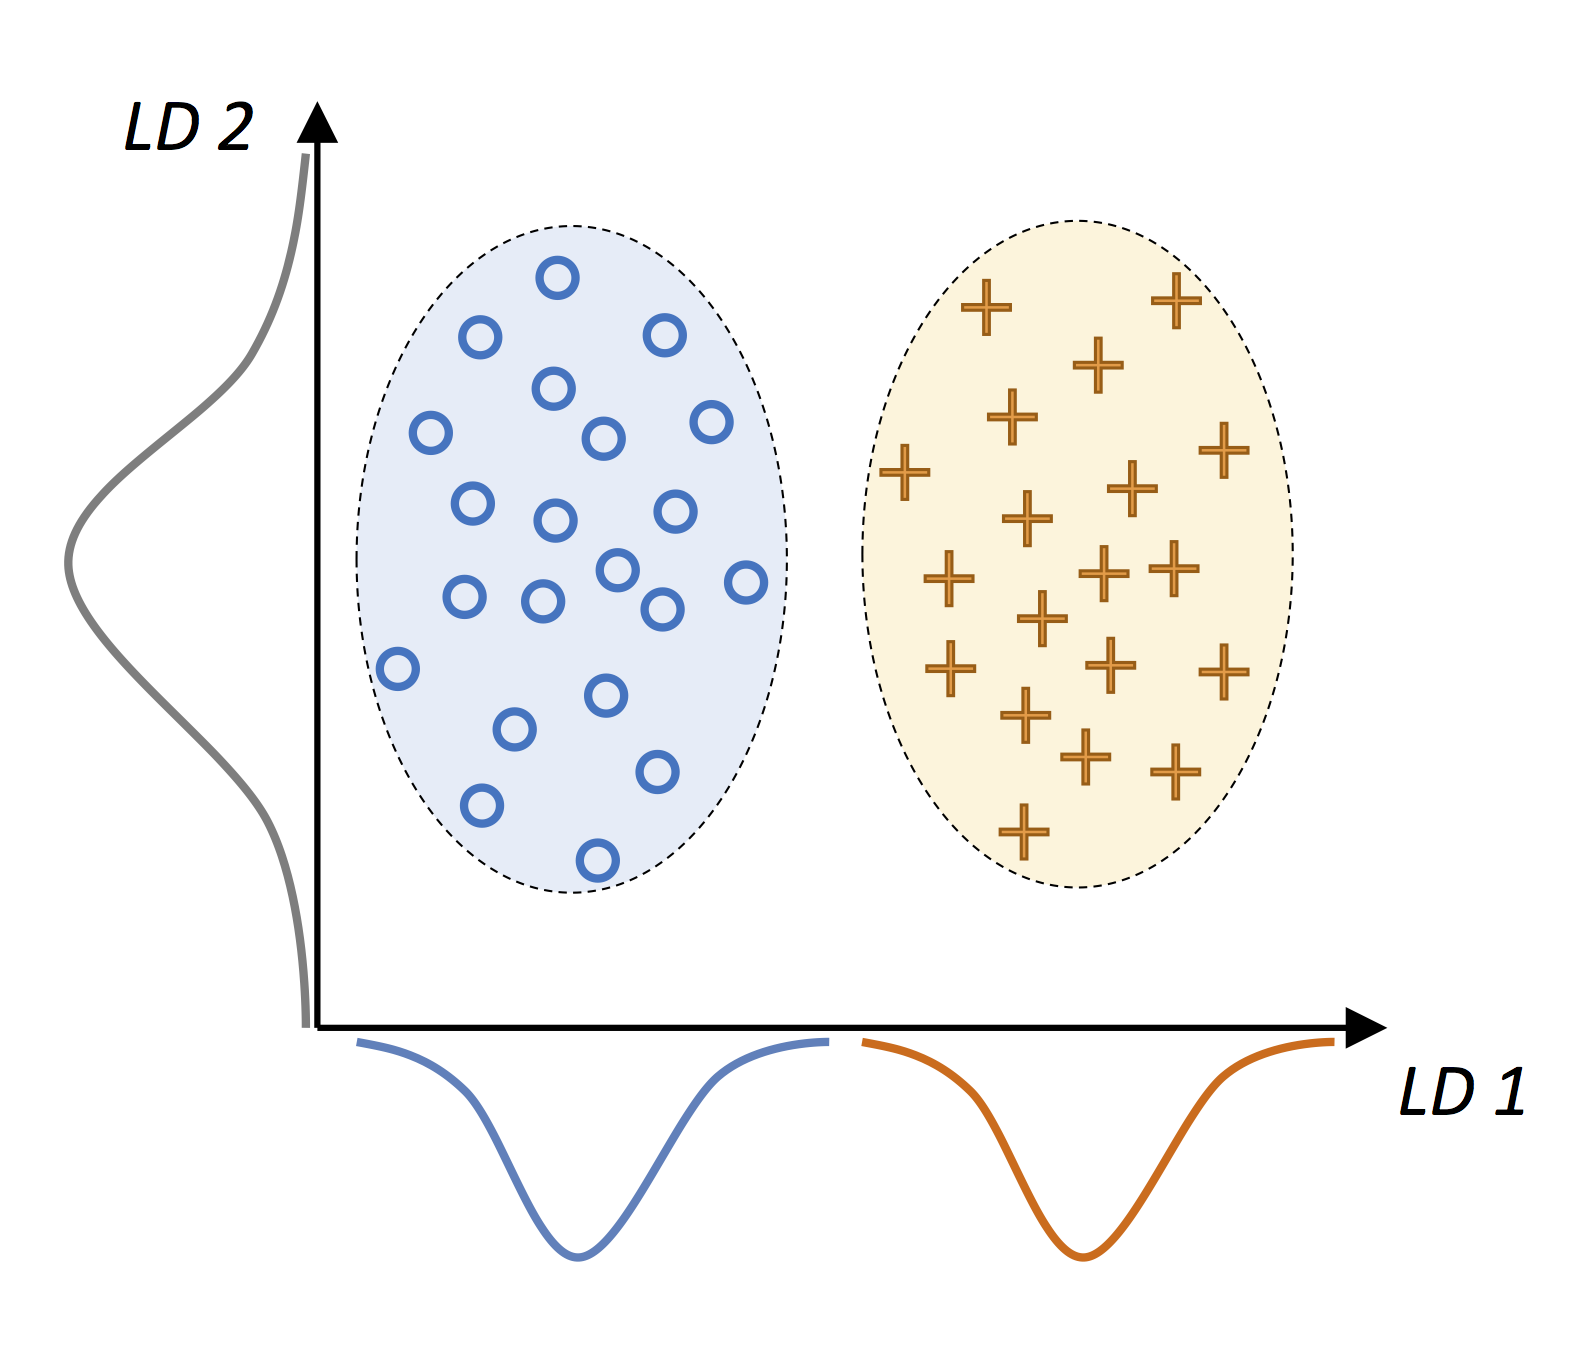

In [19]:
Image(filename=IMAGE_PATH+'05_06.png', width=400) 

Above, a linear discriminant, along the x-axis would separate the two normally distributed classes well, but not on the y-axis. Note that even if either of the two assumptions are broken, LDA still works reasonably well for dimensionality reduction.

There are 7 main steps for LDA:
- 1. Standardize the d-dimensional dataset
- 2. For each class compute the d-dimensional mean vector
- 3. Construct the between-class scatter matrix (unnormalised covariance matrix) $S_B$, and the within-class scatter matrix $S_W$
- 4. Compute the eigenvectors and eigenvalues of the matrix $S_W^{-1}S_B$
- 5. Sort the eigenvalues
- 6. Choose the largest k eigen-pairs by eigenvalue, to construct a dxk - dimensional transformation matrix **W**; the eigenvectors being columns of this matrix
- 7. Project the samples onto the new feature subspace using **W**

### 1-3. Compute the Scatter Matricies

note that we can just use the already standardised data from before.

In [20]:
X_train_std; X_test_std; y_train; y_test;
np.set_printoptions(precision=4)
print(X_train_std.shape, y_train.shape)
print(X_train_std[0])

(124, 13) (124,)
[ 0.7123  2.2205 -0.1303  0.0596 -0.5043 -0.5283 -1.24    0.8412 -1.0522
 -0.2922 -0.2002 -0.8216 -0.6295]


In [21]:
mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))
    print('MV {}: {}\n'.format(label, mean_vecs[label-1]))

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



using the mean vectors we can compute the within-class scatter matrix:
$$S_W = \sum^c_{i=1} n_i \Sigma_i $$
where $\Sigma_i$ are the class covariance matricies, given by:
$$\Sigma_i = \frac{1}{n_i} \sum^c_{x\in D_i} (x-m_i)(x-m_i)^T$$

Similarly we can compute the between-class covariance matricies, in one step:
$$S_B = \sum^c_{i=1} n_i (m_i - m)(m_i - m)^T$$

In [22]:
d = X_train_std.shape[1]  # number of columns (features)

In [23]:
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W +=  class_scatter
print('Scaled within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Scaled within-class scatter matrix: 13x13


In [24]:
S_B = np.zeros((d, d))
mean_overall = np.mean(X_train_std, axis=0)
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)  # make column vector
    mean_overall = mean_overall.reshape(d, 1)  # make column vector
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


### 3-6. Selecting linear discriminants 

In [25]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
print('Eigenvalues in descending order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])
# 8.0695598745164 [-0.1585+0.j  0.0982+0.j -0.0157+0.j  0.1587+0.j -0.0206+0.j  0.1885+0.j -0.7156+0.j -0.0796+0.j  0.0073+0.j  0.3434+0.j -0.0255+0.j -0.3201+0.j -0.4053+0.j]
# 4.123807374708671 [-0.4078+0.j -0.1817+0.j -0.3475+0.j  0.3098+0.j -0.0644+0.j  0.0736+0.j 0.3031+0.j -0.0011+0.j  0.0722+0.j -0.2792+0.j  0.2447+0.j -0.0449+0.j -0.5809+0.j]

Eigenvalues in descending order:

349.6178089059939
172.76152218979388
3.7853134512521556e-14
2.117398448224407e-14
1.5164618894178885e-14
1.5164618894178885e-14
1.3579567140455979e-14
1.3579567140455979e-14
7.587760371654683e-15
5.906039984472233e-15
5.906039984472233e-15
2.256441978569674e-15
0.0


There are only two non-zero eigenvalues. We could plot the linear discrimininants by decreasing eigenvalues as before, however the outcome is fairly obvious. The final thing to do is to simply stack the two eigen vector columns:

In [26]:
w = np.hstack( (eigen_pairs[0][1][:, np.newaxis].real, eigen_pairs[1][1][:, np.newaxis].real) )
print('Matrix W:\n', w)

Matrix W:
 [[-0.1481 -0.4092]
 [ 0.0908 -0.1577]
 [-0.0168 -0.3537]
 [ 0.1484  0.3223]
 [-0.0163 -0.0817]
 [ 0.1913  0.0842]
 [-0.7338  0.2823]
 [-0.075  -0.0102]
 [ 0.0018  0.0907]
 [ 0.294  -0.2152]
 [-0.0328  0.2747]
 [-0.3547 -0.0124]
 [-0.3915 -0.5958]]


### 7. Projecting samples onto the new feature space

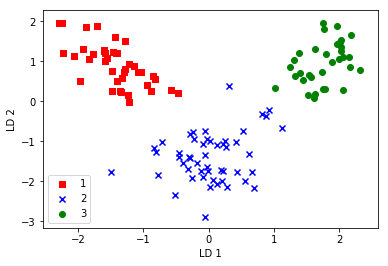

In [27]:
X_train_lda = X_train_std.dot(w)
colours = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colours, markers):
    plt.scatter(X_train_lda[y_train==l, 0], X_train_lda[y_train==l, 1] * (-1.0), c=c, label=l, marker=m)
plt.xlabel('LD 1'); plt.ylabel('LD 2')
plt.legend()
plt.show()

clearly these are perfectly linearly seperable

## Using Sklearn (LDA)

In [28]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda  = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

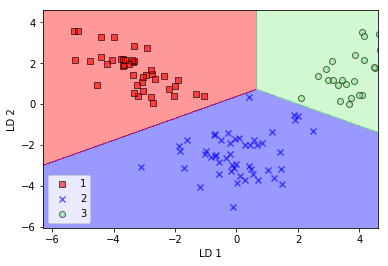

In [29]:
lr = LogisticRegression(solver='lbfgs', multi_class='auto')
lr = lr.fit(X_train_lda, y_train)
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1'); plt.ylabel('LD 2')
plt.legend()
plt.show()

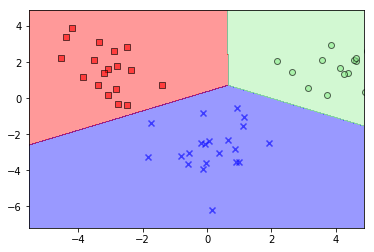

In [30]:
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test, classifier=lr)

# Kernel Principal Component Analysis (KPCA) <a name='kpca'></a>

## Theory

Recalling the standard approach to PCA, we computed the covariance between two features (not datapoints) k & j:
$$ \sigma_{jk} = \frac{1}{n}\sum^n_{i=1} (x_j^{(i)} - \mu_j)(x_k^{(i)} - \mu_k)$$
where $\mu$ represents the sample mean of a particular attribute/feature. Since standardising features sets their means to zero, we can calculate the full covariance matrix in one step:
$$\sigma_{jk} = \frac{1}{n}\sum^n_{i=1} x_j^{(i)}x_k^{(i)} \implies \Sigma = \frac{1}{n} \sum^n_{i=1} \boldsymbol{x}^{(i)} \boldsymbol{x}^{(i)^T} $$
Clearly this is possible to employ the kernel trick as we just have a dot product between two features. The kernel trick allows us to avoid calculating the pairwise dot products of the samples of $x$ under $\phi$ explicitly, by using a kernel function: $\kappa(\boldsymbol{x}^{(i)}, \boldsymbol{x}^{(j)}) = \phi(\boldsymbol{x}^{(i)})^T\phi(\boldsymbol{x}^{(j)})$

The **derivation** of the kernel matrix is as follows (note the covariance matrix is symmetrix so the transpose can be flipped in the second step):

$$ \Sigma = \frac{1}{n} \sum^n_{i=1} \phi(\boldsymbol{x}^{(i)})\phi(\boldsymbol{x}^{(j)})^T  = \frac{1}{n} \phi(\boldsymbol{X}) \phi(\boldsymbol{X})^T = \frac{1}{n} \phi(\boldsymbol{X})^T \phi(\boldsymbol{X}) $$

Now we write the eigenvalue equation, $\Sigma\boldsymbol{v} = \lambda \boldsymbol{v}$ by substituting in the above:

$$ \frac{1}{n} \phi(\boldsymbol{X})^T \phi(\boldsymbol{X}) \boldsymbol{v} = \lambda \boldsymbol{v} \implies \frac{1}{n} \phi(\boldsymbol{X}) \phi(\boldsymbol{X})^T \phi(\boldsymbol{X}) \boldsymbol{v} = \lambda \phi(\boldsymbol{X}) \boldsymbol{v} $$

Letting $\boldsymbol{v} = \phi(\boldsymbol{X})^T \boldsymbol{a}$:

$$ \frac{1}{n} \phi(\boldsymbol{X}) \phi(\boldsymbol{X})^T \phi(\boldsymbol{X}) \phi(\boldsymbol{X})^T \boldsymbol{a} = \lambda \phi(\boldsymbol{X}) \phi(\boldsymbol{X})^T \boldsymbol{a} \implies \frac{1}{n} \phi(\boldsymbol{X}) \phi(\boldsymbol{X})^T \boldsymbol{a} = \lambda \boldsymbol{a}  $$

$$ \implies \frac{1}{n} \boldsymbol{K} \boldsymbol{a} = \lambda \boldsymbol{a} $$

Where $\boldsymbol{K}$ is the symmetric kernel (Gram) matrix, which is equivalent to the covariance matrix in the case of PCA.

The most **commonly used** kernels are as follows:

- Polynomial kernel (the dot product kernel in sklearn): 
    
    $$\kappa(\boldsymbol{x}^{(i)}, \boldsymbol{x}^{(j)}) = (\boldsymbol{x}^{(i)^T} \boldsymbol{x}^{(j)} + \theta )^p $$ where $\theta$ is the threshold and p is the power, which is specified by the user. 


- Hyperbolic tangent/sigmoid kernel: 

    $$\kappa(\boldsymbol{x}^{(i)}, \boldsymbol{x}^{(j)}) = tanh(\eta \boldsymbol{x}^{(i)^T} \boldsymbol{x}^{(j)} + \theta ) $$


- Radial Basis Function (RBF), or Gaussian Kernel: 

    $$\kappa(\boldsymbol{x}^{(i)}, \boldsymbol{x}^{(j)}) = exp(- \frac{||\boldsymbol{x}^{(i)^T} - \boldsymbol{x}^{(j)}||^2}{2\sigma^2})  = exp(- \gamma ||\boldsymbol{x}^{(i)^T} - \boldsymbol{x}^{(j)}||^2) $$ where $\gamma = 1/2\sigma^2$
    
    
    

## Implementation

There are three steps to implementation:

1. compute the kernel between each pair, to find the Gram matrix **K**
2. Center the kernel matrix, **K** using the following equation:
    
    $$\boldsymbol{K}' = \boldsymbol{K} - (\frac{1}{n} J_n) \boldsymbol{K} - \boldsymbol{K} (\frac{1}{n} J_n) + (\frac{1}{n} J_n) \boldsymbol{K} (\frac{1}{n} J_n) $$ 
    where $J_n$ is the is the nxn square all-ones matrix. This is necessary since we have already standardised the data, but we cannot guarantee that the new features are centered on zero, hence we re-center kernel.

3. Collect the top k eigenevectors of the centered kernel matrix based on their eighenvalues. In contrast to standard PCA the eigenvectors are not the principal axes, but the samples already projected onto these axes.

### Define a RBF kernel

In [31]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np

In [32]:
def rbf_kernel_pca(X, gamma, n_components):
    print('X: {},  $\gamma$: {},   n_components: {}'.format(X.shape, gamma, n_components))
    
    # calculate pairwise squared euclidean distances in the MxN dimensional dataset
    sq_dists = pdist(X, 'sqeuclidean') # gives list of 99+98+...+0 = 100*(99+0)/2 = 4950
    
    # convert pairwise distances into a square matrix
    mat_sq_dists = squareform(sq_dists) # 100*100 as the distances are repeated in the reflection
    
    # compute the symmetrux kernel matrix
    K = exp(-gamma * mat_sq_dists)
    
    # center the kernel matrix
    N = K.shape[0]
    one_n = np.ones((N,N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    
    # get the eigenpairs
    # scipy.linalg.eigh returns them in ascending order, so flip them 
    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]
    
    # collect the top k eigenvectors (projected samples)
    X_pc = np.column_stack( (eigvecs[:, i] for i in range(n_components)) )
    return X_pc
    

### Ex1 Separating Half-Moons

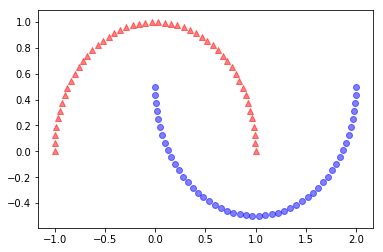

In [33]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples = 100, random_state=123)
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', marker='o', alpha=0.5)
plt.show()

If we try **standard PCA** clearly this doens't work (shifting the markers slightly in the y direction so that they are visable)

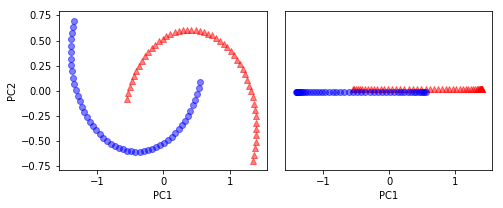

In [34]:
from sklearn.decomposition import PCA

scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1],
              color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1],
              color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_spca[y == 0, 0], np.zeros((50, 1)) + 0.02,
              color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((50, 1)) - 0.02,
              color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
# plt.savefig('images/05_13.png', dpi=300)
plt.show()

Now implementing our **kernel**

X: (100, 2),  $\gamma$: 15,   n_components: 2


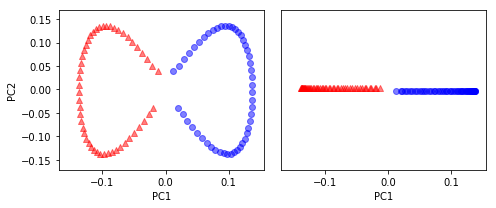

In [35]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], 
            color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1],
            color='blue', marker='o', alpha=0.5)

ax[1].scatter(X_kpca[y==0, 0], np.zeros((50,1))+0.02, 
            color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((50,1))-0.02,
            color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')

plt.tight_layout()
# plt.savefig('images/05_14.png', dpi=300)
plt.show()

### Ex2 Separating Concentric Circles

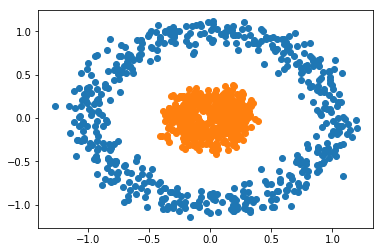

In [37]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])
plt.show()

X: (1000, 2),  $\gamma$: 15,   n_components: 2


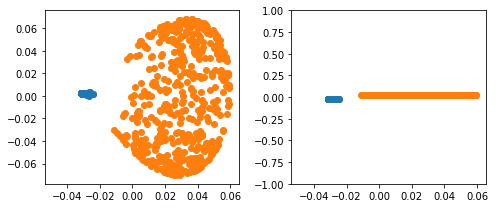

In [42]:
# given some value of gamma, where gamma is the length scale parameter, expand the inputs
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y==0, 0], X_kpca[y==0, 1])
ax[0].scatter(X_kpca[y==1, 0], X_kpca[y==1, 1])
ax[1].scatter(X_kpca[y==0, 0], np.zeros((500, 1))-0.02)
ax[1].scatter(X_kpca[y==1, 0], np.zeros((500, 1))+0.02)
ax[1].set_ylim([-1, 1])
plt.tight_layout()
plt.show()

## Projecting New DataPoints

Previously our `rbf_kernel_pca` function takes our data (100x1 dimensional), **X old**, and returns a transformed dataset (100x100 dimensional), **X kpca**. If we have new datapoints that we also want to project, for example a test set, we need to project these. This can be done with:

$$ \boldsymbol{x_{kpca}}' = \phi(\boldsymbol{x}')^T\boldsymbol{v} $$

Where we have simply taken a basis vector that we previously computed with the training set, $\boldsymbol{v}$, and projected the new transformed datapoint onto it with a dot product.

Fortunately we can use the kernel trick so we don't have to calculate this explicitly. Note that kernel PCA is a memory-based method, so we have to re-use the original training set each time we want to project new samples: we have to calculate the pairwise RBF kernel (similarity) between each ith sample in the training dataset and the new sample **x**.

$$\phi(\boldsymbol{x}')^T\boldsymbol{v} = \sum_i a^{(i)} \phi(\boldsymbol{x}')^T \phi(\boldsymbol{x}^{(i)}) = \sum_i a^{(i)} \kappa(\boldsymbol{x}', \boldsymbol{x}^{(i)})$$

Which comes from the fact that $\boldsymbol{v} = \sum_i a^{(i)} \phi(\boldsymbol{x}^{(i)}) = \phi(\boldsymbol{X})^T \boldsymbol{a}$, where $\boldsymbol{a}$ satisfies the eigen equation: $\boldsymbol{Ka} = \lambda \boldsymbol{a}$

The final step, after computing the similarity between the new sample and the samples in the training set, is the normalise the eigenvector $\boldsymbol{a}$ by its eigenvalues.